In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats
import os
import os.path

import scipy
from scikits import bootstrap as bootstrap
from collections import *
from scipy.interpolate import spline

from bs4 import BeautifulSoup
import urlparse
from urllib2 import urlopen
from urllib import urlretrieve
import urllib
import os
import sys
import re

from leven import levenshtein       
import numpy as np
from sklearn.cluster import dbscan

from fuzzywuzzy import fuzz
import textwrap

import operator
from scipy.stats import entropy
from numpy.linalg import norm

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.0)

In [46]:
section_to_func_counts = defaultdict(Counter)
functions = set()
with open('../results/citation-graph/custom-weights6/cite-func.all.tsv') as f:    
    for line in f: 
        cols = line[:-1].split('\t')
        section = cols[3]
        function = cols[4]
        section_to_func_counts[section][function] += 1
        functions.add(function)

In [47]:
how_citing_df = []
        
for section, cite_counts in section_to_func_counts.iteritems():
    dist = { 'Section': section} 
    s = float(sum(cite_counts.values()))
    for func in functions:
        dist[func] = cite_counts[func] / s
        
    how_citing_df.append(dist)

how_citing_df = pd.DataFrame(how_citing_df)        

In [11]:
how_citing_df.head(20)

,Background,CompareOrContrast,Extends,Future,Motivation,Section,Uses
0,0.373155,0.202540,0.063508,0.074150,0.028493,Motivation,0.258153
1,0.534636,0.055138,0.092713,0.000600,0.282552,Introduction,0.034361
2,0.031749,0.450080,0.052915,0.363618,0.013778,Discussion,0.087859
3,0.181547,0.244851,0.074327,0.083054,0.027564,Other_Section,0.388658
4,0.064977,0.377590,0.063669,0.161135,0.017904,Results,0.314725
5,0.088363,0.209377,0.070032,0.059747,0.034234,Methodology,0.538247
6,0.001089,0.242978,0.042456,0.647943,0.001306,Conclusion,0.064228
7,0.044209,0.238606,0.052244,0.079038,0.018988,Evaluation,0.566914
8,0.375111,0.111603,0.065988,0.008857,0.015500,Abstract,0.422941
9,0.432507,0.399488,0.036606,0.000515,0.013907,Related_Work,0.116977


In [42]:
[sum(x) for x in how_citing_df[['Background', 'Extends']].itertuples(index=False)]

[0.46073903002309469,
 0.61848935421432338,
 0.092278269184795592,
 0.25952322437945441,
 0.1159944042900443,
 0.14638751058937433,
 0.484460976738605,
 0.075265171695645852,
 0.46862745098039216,
 0.038500251635631609]

NameError: name 'df' is not defined

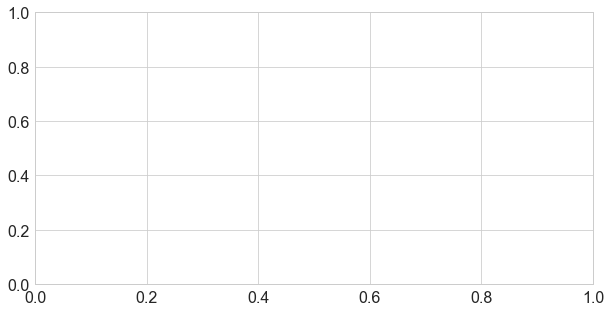

In [43]:
# Create the general blog and the "subplots" i.e. the bars
f, ax1 = plt.subplots(1, figsize=(10,5))

# Set the bar width
bar_width = 0.75

# positions of the left bar-boundaries
bar_l = [i+1 for i in range(len(df['pre_score']))]

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l]

# Create a bar plot, in position bar_1
ax1.bar(bar_l,
        # using the pre_score data
        df['pre_score'],
        # set the width
        width=bar_width,
        # with the label pre score
        label='Pre Score',
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='#F4561D')

# Create a bar plot, in position bar_1
ax1.bar(bar_l,
        # using the mid_score data
        df['mid_score'],
        # set the width
        width=bar_width,
        # with pre_score on the bottom
        bottom=df['pre_score'],
        # with the label mid score
        label='Mid Score',
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='#F1911E')

# Create a bar plot, in position bar_1
ax1.bar(bar_l,
        # using the post_score data
        df['post_score'],
        # set the width
        width=bar_width,
        # with pre_score and mid_score on the bottom
        bottom=[i+j for i,j in zip(df['pre_score'],df['mid_score'])],
        # with the label post score
        label='Post Score',
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='#F1BD1A')

# set the x ticks with names
plt.xticks(tick_pos, df['first_name'])

# Set the label and legends
ax1.set_ylabel("Total Score")
ax1.set_xlabel("Test Subject")
plt.legend(loc='upper left')

# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

In [48]:
def stacked_boxplot(df, x, bar_width=0.75, x_order=None, hue_order=None, xlabel=None, ylabel=None):
    # Create the general blog and the "subplots" i.e. the bars
    f, ax1 = plt.subplots(1, figsize=(10,5))

    if x_order is None:
        x_order = list(set(df[x]))
    
    x_ind = {}
    x_remap = {}
    for i, xn in enumerate(df[x]):
        x_ind[xn] = i
    for i, xn in enumerate(x_order):
        if xn in x_ind:
            x_remap[x_ind[xn]] = i
        else:
            raise Exception('Unknown x-axis item: ' + xn)
    
    
    if hue_order is None:
        hue_order = [c for c in df.columns if (c != x)]
        
    # positions of the left bar-boundaries
    bar_l = [i+1 for i in range(len(x_order))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l]

    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666'] 
    # ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']        

    bottom = [0] * len(x_order)
    
    for i, h in enumerate(hue_order):
        orig_hue_vals = df[h]
        x_vals = []
        for j, hv in enumerate(orig_hue_vals):
            if j in x_remap:
                x_vals.append((hv, x_remap[j]))
        #print x_vals
        x_vals.sort(key=operator.itemgetter(1))
        x_vals = [x[0] for x in x_vals]
        #print x_vals

        ax1.bar(bar_l,
                x_vals,
                width=bar_width,
                label=h,
                bottom=bottom,
                color=colors[i % len(colors)])

        # print bottom
        for i, v in enumerate(x_vals):
            bottom[i] += v

    # set the x ticks with names
    plt.xticks(tick_pos, x_order)

    # Set the label and legends
    if ylabel is not None:
        ax1.set_ylabel(ylabel)
    if xlabel is not None:
        ax1.set_xlabel(xlabel)

    # Set a buffer around the edge
    plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
 
    plt.legend(ncol=1, fontsize=20, loc='upper left', bbox_to_anchor=(1., 0.8))
    plt.gca().set_axis_bgcolor('white')

    ax = plt.gca()
    #ax.set_ylabel(ylabel, fontsize=22)
    #ax.set_xlabel(xlabel, fontsize=22)  
    ax.grid(False)
    plt.tight_layout()   
    plt.xticks(rotation=-45)
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")    
    return f

In [49]:
print set(section_to_func_counts.iterkeys())

set(['Motivation', 'Introduction', 'Discussion', 'Other_Section', 'Results', 'Methodology', 'Conclusion', 'Evaluation', 'Abstract', 'Related_Work'])


In [54]:

# how_citing_df['Section'].replace('Related_Work', 'Related Work',inplace=True)
how_citing_df.rename(columns={'CompareOrContrast': 'Compare or Contrast'}, inplace=True)


In [55]:
how_citing_df.head()

,Background,Compare or Contrast,Extends,Future,Motivation,Section,Uses
0,0.408391,0.136644,0.052348,0.064665,0.028868,Motivation,0.309084
1,0.542803,0.034225,0.075686,0.000253,0.286930,Introduction,0.060102
2,0.043988,0.409515,0.048291,0.335166,0.012431,Discussion,0.150610
3,0.199143,0.180711,0.060380,0.064282,0.025144,Other_Section,0.470340
4,0.072161,0.310329,0.043833,0.130333,0.017020,Results,0.426323


/Users/jurgens/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


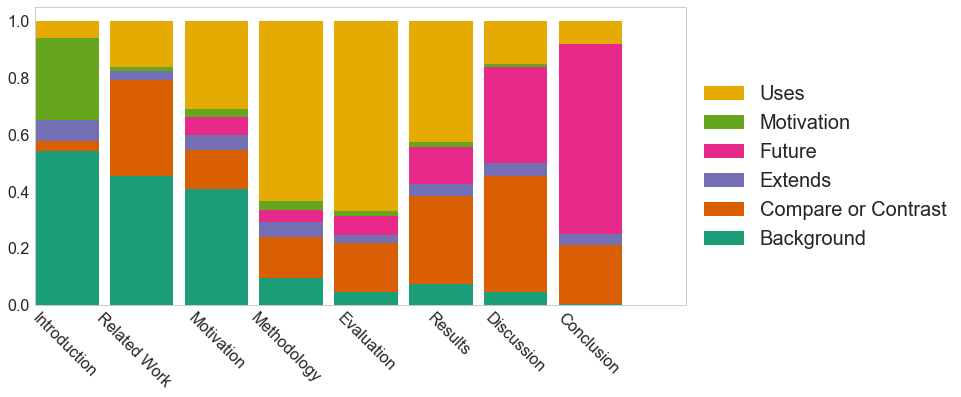

In [58]:
x_order = [
 'Introduction', 'Related Work', 'Motivation', 'Methodology', 'Evaluation',  'Results',  'Discussion','Conclusion'
]
g = stacked_boxplot(how_citing_df, 'Section', x_order=x_order, bar_width=0.85)

handles, labels = g.gca().get_legend_handles_labels()
g.gca().legend(reversed(handles), reversed(labels), loc='upper left', ncol=1, fontsize=20, bbox_to_anchor=(1., 0.8))

g.savefig('section-dist.2.pdf', bbox_inches='tight')

#handles, labels = g.get_legend_handles_labels()
#g.legend(reversed(handles), reversed(labels), loc='upper left')